# Flocking of birds

The flock model illustrates how flocking behavior can emerge when each bird follows three simple rules:

- maintain a minimum distance from other birds to avoid collision
- fly towards the average position of neighbors
- fly in the average direction of neighbors

## Model setup

In [1]:
using Agents, LinearAlgebra

mutable struct Bird <: AbstractAgent
    id::Int
    pos::NTuple{2,Float64}
    vel::NTuple{2,Float64}   # Moving in ContinuousSpace
    speed::Float64           # How far the bird travels
    cohere_factor::Float64   # the importance of maintaining the average position of neighbors
    separation::Float64      # the minimum distance a bird must maintain from its neighbors
    separate_factor::Float64 # the importance of maintaining the minimum distance from neighboring birds
    match_factor::Float64    # the importance of matching the average trajectory of neighboring birds
    visual_distance::Float64 # the distance a bird can see and defines a radius of neighboring birds
end


Update message: Agents v5
Welcome to this new major version of Agents.jl!
Noteworthy changes:

* Schedulers have been reworked to be more performant and allocate
  less. This means that most scheduler names have been deprecated from
  functions to types, such as `by_type` -> `ByType`. See changelog for
  full list!
* See the CHANGELOG.md or online docs for more!


In [2]:
function initialize_model(;
    n_birds = 100,
    speed = 1.0,
    cohere_factor = 0.25,
    separation = 4.0,
    separate_factor = 0.25,
    match_factor = 0.01,
    visual_distance = 5.0,
    extent = (100, 100),
    spacing = visual_distance / 1.5,
)
    space2d = ContinuousSpace(extent, spacing)
    model = ABM(Bird, space2d, scheduler = Schedulers.randomly)
    for _ in 1:n_birds
        vel = Tuple(rand(model.rng, 2) * 2 .- 1)
        add_agent!(
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
        )
    end
    return model
end

initialize_model (generic function with 1 method)

In [3]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)
    N = 0
    match = separate = cohere = (0.0, 0.0)
    # Calculate behaviour properties based on neighbors
    for id in neighbor_ids
        N += 1
        neighbor = model[id].pos
        heading = neighbor .- bird.pos

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading
        if edistance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
    end
    N = max(N, 1)
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    move_agent!(bird, model, bird.speed)
end

agent_step! (generic function with 1 method)

## Plotting

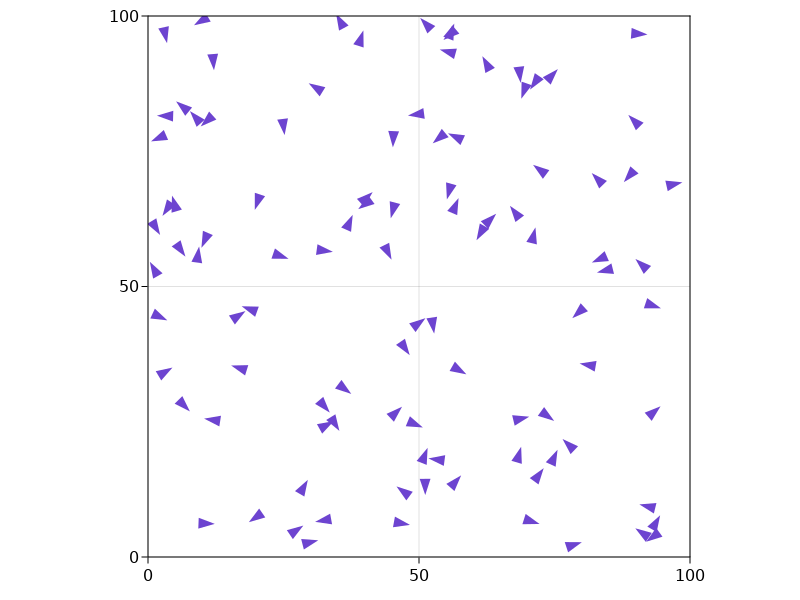

In [4]:
using InteractiveDynamics
using CairoMakie

const bird_polygon = Polygon(Point2f[(-0.5, -0.5), (1, 0), (-0.5, 0.5)])
function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) #+ π/2 + π
    scale(rotate2D(bird_polygon, φ), 2)
end

model = initialize_model()
figure, = abmplot(model; am = bird_marker)
figure

## Animation

In [5]:
model = initialize_model()

abmvideo(
    "flocking.mp4", model, agent_step!;
    am = bird_marker,
    framerate = 20, 
    frames = 200,
    title = "Flocking"
)

using Base64

function display_mp4(filename)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
        Base64.base64encode(open(read, filename)),"""" type="video/mp4"></video>"""))
end

display_mp4("flocking.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAMQGJtZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOSBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAC9YZYiEADf//veBvzLLXSAayXH5530yr9P7HtM0Uz9Q/ChAAAADAAADAADXt3LApOrcoLlACT0RmZNbVFt4tQCJ6//gKF8XTdglvjvurP6dl6dL2/h+pbJJsUiKqJ6Cd1Dbh/t+NNP5d3Xeru9r+sYsQKU0SNnLPYfRywmjDiwG0PmhtPujbWuY8m/Hx+nUi7cI4xOKVZuXXlL21stGuZ2N9ResiDN1/yjp8E9/ZSTg1RO0gPAqmMdfsSISiax63i33gkI4VltIsxD0a0DIAv5rYJrsozH6r6fBQLBYj909GWFWcnp1Gvad/ciE5Ru/CjIsZRfVgYxs+Np5dvC3O1dCVLLY4chYurd83Oq0OHDgBEypZ3e8hYbtFA5asyItsiTEb9m/+7WEZEdO0HW7jZIsC+aX/kRQ3w5rU9bStJAEN3OFSdYMbotgrU6g+hxuN3FvaUip2b55tUu+dNplw2LSOeJHHjYQ4uinaLR5RTh6leE8cHGQfsw7lBX4oFGIU63Vkw05wB3IFuef7Vo4YzWRZeabs6LZAqI9j4LHGrDOG0qTQwEUXuJbFLrVZXhH6J+OXcZ1kyHDdA/lF4O171QO23Y+ETWRxkU8Pm9zXMv8KbOL2rhhhqFGewW2pdTa/R7aOjBh25yrDmXK2nrKIaPa6t9V83JFWrTwwDqAraq4ZJUQrkkr37gZg91fINK910NlAbL99hyaKO0DkOeP2ziR2sIVAq2xtsqaWfegOJYAT2wvh+KQPSTH9myXULbV00fsfPs1+JrW/0f4YfjP6iQ3sz1UfdXjqKMlz2JEQLhV+vg43kBb99VyqyncsFPtOiQG9N1GSZGLfDTsXs245QcmJ0pRjmPJ2JpLNCWUOfsAoakJFlR18F/PLVUEY7FYcHwcKYW3hJJAe9/E8k82eo8MKEE1tWMvwD61CX+Tb5sZTJosgdkJWtiFVL1crHxbYelb5P1yYQELMdp9l+W1bYb8sGbg6BlF7cAB3DZrzYDe1g0C1DCHz1gDZfJJan0MMBK4VLjvlY/V7cCJqJbRFs431nAWul+DJbz3My1wySSFtn0tJ4/9+senaqeolBKcXdLGLLXTHByaea11jqz3ZucgROLNVFlvIYUiCLftWQDRAjqJM8qkq+detb+dznwX3fqls71aMo3Eerl5+vUQo92ltQXiqNYsCpa/mXimb2daSmwFWFlIpl6+EDhWcs0nKhx3Y396nduLGT8sR78KdJc6109o6wYf+DhVJx5rbsUd/khwwiz47DOASYdl4a5Z/J/wowifni6W+qdtr/Lnenmz+BzU+h5+zBFnXmNN48ZHt/4amFSQEjyjyvqGOxc3O/flu6w68nQV+P3JJiGwAAAmtGBrgUTrua8/1GVWZ0iQ5RauCJV04PR0QyK3bdvONI5OTU373Fk3teg3NnWfVV8hjWJ0SDZ5Mw7J0NVZLcx2c0hCSAMD5PZjW96+rahpyjbN9957m4eMC8+5YYjzinopQuSDVUOASlyaSuVCigDhqyz1Pfa/JpFMHRm8VP0biaqHSI5jXJ3kaVDCR+i67zA9Tf/T3rPsfCGCLSyP2oDcZb/U8mQprkkaULvqNlmGaf2TOKOA3biiMPtNQ1o4b/b7JFb/2Rb9sVKdXH+DOSGsilrfE3xzZKJVO/XKfJuqUEGsnzJ6p2ksZ1Jy2hJeWTT78picHY7yy2EJsZUouRsDKCZ0B/86DCApC/tc9Khys+IZpic3T1FdjHjVnTAGyVakRpHpp6o0ysPb+JCGmb3roctt2ErBwCCtUyYbkmJTLCF9Ck07KSILMjIzGj+3Z4cp9GiBnX5q9//yKUfhx6R4AsC4aTTO94IvBQa1lCo/N9KG4JMuLfhE3ViEjyjBaQzLJxvA7XZQJXgwlYQShHNQ1cvhKuOucr+4TxxnMSfTExBw+M2ulpYZiRNTaNnPQ9mwaTc+wdjNn5zIdI7O65LGDWTcg8tDd+v60+fd2QJpshYhUP4tWfLldFJ+qCVMA9fotRd75fEyRGr8EEZcD+w+zsUV6n7RKTeriYgOvJYeo5jSryF9jFHHRj4vCGIfLivHxnvKAeLQEOvsSGVWz4Ct5xN7awt0/76P5v/+Ow2NMQa8RuPdtsyfEYpEuXDAAAWcsPlIjZZH8XJ8/is5Ed8MrOYQgscCv7Mcx6Ibh04IyLtE1dyLb6QaHVCaJ9ZqGkknqW5DYuhCXQTCaoZCLToK1HGtjeT482qs9z+wMdbxuIhLslCTXjKcMMbvhgwLtChWgF89RqddMKvTPobxy5/dSIBdi/woZzKdWO6wkIMKzccaYkaxM/BaJuxqojrL1VSC/pk3tk/i0T7DtX3r0NMmygmILpwTuRxxtF8Z8S/8/QREbt/we+ntzoLSvl0JrB2Inl4Ic78L43HU3pZi7Nn4M68ul8yUfvM2WRGhcWyWWdyGaby1G3/CU1j4QuN7JmXs/v1fiGP60kWpL2bfaZO+tNx8RLTjav6+sBrvI39fdsxgycCyhX7ypY+hsv/aMSAPAKaq2lskd+hCMB/eEO8iw/AHNoGRgeLPLv5Y869rB/vYnNR8mV/zQx1sRx64OeWgxKzValF/CRQp9Bh7e4US5xfPD01XASco9F5oyberKmLXvzR3O8XlaG3Ro82WFGbh+qADLrlpp76IBVnpHYNDMIQwq+JJJWk1mc6mnixVUjmwaysv4mdZcD27AlsJMFCCuIi9HQKgNvV5xZl7DaJJCPmyvZIKUogfwXcNS1UMrMZ2BqC3uhvrSWyLeV0tHsogcd0bmGIi9KQG3jc28UXS9qg81FBXbswNEl/FItntaK0yaPcywHHQMT0cpYkyl5wSZMmgphmHcOWNLOUoUxBnq2suvRX7fRztdyI97d1vjRA+XwZnkMrfiISHv9ghowjXzCOkSpxNExKfdAKCe6N+h+i6CwinNRU4Sj25VQK/3mW64rZrbwJBUivFEbVagfiWOWoSwhLQ02/8Znnv7E4xA7duJ3P